In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U sentence-transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 98.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 73.9 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=3cccf75bf80eb4850f0bc0c7a3614c7dd62b323d4f268581eb24b57cf4ec61e1
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets

from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
import pickle

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay


In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
from torchvision import models
from torchsummary import summary

In [ ]:
# embeddings_balanced_b_path = 'drive/MyDrive/DataBank/wordEmbedding/binary/balanced/em_1.csv'
# embeddings_balanced_b_path_im = 'drive/MyDrive/DataBank/wordEmbedding/binary/imbalanced/em_1.csv'

embeddings_balanced_b_path = 'drive/MyDrive/ThesisData/augmented_data/wordEmbedding/binary/balanced/em_1.csv'
embeddings_balanced_b_path_im = 'drive/MyDrive/ThesisData/augmented_data/wordEmbedding/binary/imbalanced/em_1.csv'

In [ ]:
plt_data_balanced = []
plt_data_imbalanced = []
plt_ROC_balanced = []
plt_ROC_imbalanced = []

plt_cohen_kappa_balanced = []
plt_cohen_kappa_imbalanced = []

In [ ]:
import sys
import numpy as np

def predictive_entropy(predictions):
    epsilon = sys.float_info.min
    predictive_entropy = -np.sum( np.mean(predictions, axis=0) * np.log(np.mean(predictions, axis=0) + epsilon),
            axis=-1)

    return predictive_entropy

#Balanced Dataset

#UNI - Directional

Adam

dataset_b.shape: 15800 768
Iteration: 1000. Loss: 0.696457028388977. Accuracy: 71.39241% F1: 71.27% cohen_kappa: 0.4278
Iteration: 2000. Loss: 0.6817677021026611. Accuracy: 75.47468% F1: 75.95% cohen_kappa: 0.5097
Iteration: 3000. Loss: 0.4078682065010071. Accuracy: 75.94937% F1: 75.66% cohen_kappa: 0.5189
Iteration: 4000. Loss: 0.5913015007972717. Accuracy: 73.41772% F1: 76.47% cohen_kappa: 0.4695
Iteration: 5000. Loss: 0.5729544758796692. Accuracy: 77.56329% F1: 76.22% cohen_kappa: 0.5509
Iteration: 6000. Loss: 0.34272095561027527. Accuracy: 75.41139% F1: 71.63% cohen_kappa: 0.5072
Iteration: 7000. Loss: 0.7111520767211914. Accuracy: 77.62658% F1: 78.12% cohen_kappa: 0.5527
Iteration: 8000. Loss: 0.6433404088020325. Accuracy: 73.00633% F1: 77.20% cohen_kappa: 0.4618
Uncertainity: 0.6123563


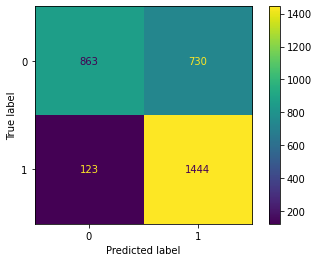

In [ ]:

dataset_b = pd.read_csv(embeddings_balanced_b_path)

dataset_b.drop(columns=['Unnamed: 0'],inplace=True)


dataset_b = dataset_b.to_numpy()


data_X = dataset_b[:,:-1]
data_X = torch.from_numpy(data_X)

data_Y = dataset_b[:,-1]
data_Y = torch.from_numpy(data_Y)

col = dataset_b.shape[1]-1

print('dataset_b.shape:',dataset_b.shape[0],col)

train_dataset = []
test_dataset = []
train_data, test_data = train_test_split(dataset_b,test_size= 0.2,random_state = 2)
predictions = []

sequence_length = 1
input_size = 768
hidden_size = 768
num_layers = 2
num_classes= 2
batch_size = 10
num_iters = 10000
learning_rate = 0.0001  # More power so we can learn faster! previously it was 0.001
check_acc_iter = 1000

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for x in train_data:
  train_dataset.append((torch.from_numpy(x[:-1]),int(x[-1])))

for x in test_data:
  test_dataset.append((torch.from_numpy(x[:-1]),int(x[-1])))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,drop_last=True)   # It's better to shuffle the whole training dataset!

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,drop_last=True)


class RNN_UNI(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
      super(RNN_UNI, self).__init__()
      self.hidden_size= hidden_size
      self.num_layers = num_layers

      self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # For uni Directional RNN
      # self.fc = nn.Linear(hidden_size, num_classes) #For uni Directional

      self.fc_1 = nn.Linear(hidden_size, 512) #For uni Directional
      self.fc_2 = nn.Linear(512, 256) #For uni Directional
      self.fc_3 = nn.Linear(256, 128) #For uni Directional
      self.fc_4 = nn.Linear(128, 64) #For uni Directional
      self.fc_5 = nn.Linear(64, num_classes) #For uni Directional


      self.relu = nn.ReLU()
      self.softmax = nn.Softmax(dim = 1)
      self.dropout = nn.Dropout(.1)


  def forward(self, x):
      # set initial hidden and cell states
      h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) #For uni Directional

      #Forward Propagation
      out, _  = self.rnn(x,h0) #out: tensor of shape (batch size, seq_length, hidden_size)

      # Decode the hidden state of the last time step
      # out = self.fc(out[:, -1, :])

      out = self.fc_1(out[:, -1, :])
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_2(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_3(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_4(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_5(out)

      logits = self.softmax(out)
      return logits
'''
INSTANTIATE MODEL CLASS
'''
model = RNN_UNI( input_size, hidden_size, num_layers, num_classes)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
# print(num_epochs)


'''
TRAIN THE MODEL
'''
iter = 0
mx_acc = 0
y_score_pos = []
y_score_neg = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        # print('before:',images.shape)

        images = images.reshape(batch_size, sequence_length, input_size).to(device)

        # print('after:',images.shape)


        labels = labels.to(device)


        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images.float())


        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        if iter % check_acc_iter == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            y_pred = []
            y_true = []
            pos_probs = []
            neg_probs = []

            for i_model, (images, labels) in enumerate(test_loader):

                images = images.reshape(batch_size, sequence_length, input_size).to(device)

                # Forward pass only to get logits/output
                outputs = model(images.float())

                np_output = outputs.detach().cpu().numpy()

                if i_model == 0:
                    predictions = np_output
                else:
                    predictions = np.vstack((predictions, np_output))

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                pos_probs.extend(outputs[:,0].tolist())
                neg_probs.extend(outputs[:,1].tolist())

                # Total number of labels
                total += labels.size(0)

                y_pred.extend(predicted.tolist())
                y_true.extend(labels.tolist())

                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            f1 = f1_score(y_true,y_pred,zero_division='warn') * 100
            cohen_kappa = cohen_kappa_score(y_true, y_pred)

            if mx_acc < accuracy:
              mx_acc = accuracy
              y_score_pos = pos_probs
              y_score_neg = neg_probs

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {:.5f}% F1: {:.2f}% cohen_kappa: {:.4f}'.format(iter, loss.item(), accuracy, f1, cohen_kappa))
            plt_data_balanced.append(('RNN-UNI',iter,'Adam',loss.item()))


pos_fpr, pos_tpr, pos_thresholds = roc_curve(y_true, y_score_pos)
neg_fpr, neg_tpr, neg_thresholds = roc_curve(y_true, y_score_neg)

roc_auc_pos = roc_auc_score(y_true, y_score_pos)
roc_auc_neg = roc_auc_score(y_true, y_score_neg)

plt_ROC_balanced.append((neg_fpr,neg_tpr,roc_auc_pos,'RNN-UNI','Adam'))

uncertainity = predictive_entropy(predictions)
print("Uncertainity:", uncertainity)

# confusion_mat = confusion_matrix(y_true, y_pred)
# sns.heatmap(confusion_mat, annot=True)
# print("confusion matrix:\n", confusion_mat)


ConfusionMatrixDisplay.from_predictions(
   y_true, y_pred)

plt.show()

NAdam

dataset_b.shape: 15800 768
Iteration: 1000. Loss: 0.4931401312351227. Accuracy: 71.36076% F1: 65.65% cohen_kappa: 0.4257
Iteration: 2000. Loss: 0.5986504554748535. Accuracy: 75.28481% F1: 76.44% cohen_kappa: 0.5061
Iteration: 3000. Loss: 0.3900972902774811. Accuracy: 74.52532% F1: 77.34% cohen_kappa: 0.4916
Iteration: 4000. Loss: 0.6482633352279663. Accuracy: 75.88608% F1: 77.47% cohen_kappa: 0.5183
Iteration: 5000. Loss: 0.48502740263938904. Accuracy: 75.85443% F1: 73.07% cohen_kappa: 0.5163
Iteration: 6000. Loss: 0.3781771659851074. Accuracy: 77.56329% F1: 76.94% cohen_kappa: 0.5511
Iteration: 7000. Loss: 0.3266938328742981. Accuracy: 78.13291% F1: 78.72% cohen_kappa: 0.5629
Iteration: 8000. Loss: 0.6483613848686218. Accuracy: 76.83544% F1: 74.42% cohen_kappa: 0.5360
Uncertainity: 0.68258697


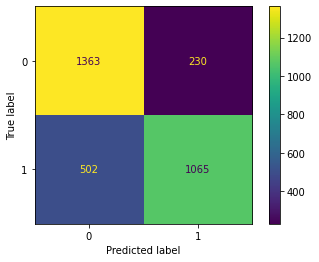

In [ ]:

dataset_b = pd.read_csv(embeddings_balanced_b_path)

dataset_b.drop(columns=['Unnamed: 0'],inplace=True)


dataset_b = dataset_b.to_numpy()


data_X = dataset_b[:,:-1]
data_X = torch.from_numpy(data_X)

data_Y = dataset_b[:,-1]
data_Y = torch.from_numpy(data_Y)

col = dataset_b.shape[1]-1

print('dataset_b.shape:',dataset_b.shape[0],col)

train_dataset = []
test_dataset = []
train_data, test_data = train_test_split(dataset_b,test_size= 0.2,random_state = 2)

sequence_length = 1
input_size = 768
hidden_size = 768
num_layers = 2
num_classes= 2
batch_size = 10
num_iters = 10000
learning_rate = 0.0001  # More power so we can learn faster! previously it was 0.001
check_acc_iter = 1000

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for x in train_data:
  train_dataset.append((torch.from_numpy(x[:-1]),int(x[-1])))

for x in test_data:
  test_dataset.append((torch.from_numpy(x[:-1]),int(x[-1])))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,drop_last=True)   # It's better to shuffle the whole training dataset!

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,drop_last=True)


class RNN_UNI(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
      super(RNN_UNI, self).__init__()
      self.hidden_size= hidden_size
      self.num_layers = num_layers

      self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # For uni Directional RNN
      # self.fc = nn.Linear(hidden_size, num_classes) #For uni Directional

      self.fc_1 = nn.Linear(hidden_size, 512) #For uni Directional
      self.fc_2 = nn.Linear(512, 256) #For uni Directional
      self.fc_3 = nn.Linear(256, 128) #For uni Directional
      self.fc_4 = nn.Linear(128, 64) #For uni Directional
      self.fc_5 = nn.Linear(64, num_classes) #For uni Directional


      self.relu = nn.ReLU()
      self.softmax = nn.Softmax(dim = 1)
      self.dropout = nn.Dropout(.1)


  def forward(self, x):
      # set initial hidden and cell states
      h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) #For uni Directional

      #Forward Propagation
      out, _  = self.rnn(x,h0) #out: tensor of shape (batch size, seq_length, hidden_size)

      # Decode the hidden state of the last time step
      # out = self.fc(out[:, -1, :])

      out = self.fc_1(out[:, -1, :])
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_2(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_3(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_4(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_5(out)

      logits = self.softmax(out)
      return logits
'''
INSTANTIATE MODEL CLASS
'''
model = RNN_UNI( input_size, hidden_size, num_layers, num_classes)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
# print(num_epochs)


'''
TRAIN THE MODEL
'''
iter = 0
mx_acc = 0
y_score_pos = []
y_score_neg = []
predictions = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        # print('before:',images.shape)

        images = images.reshape(batch_size, sequence_length, input_size).to(device)

        # print('after:',images.shape)


        labels = labels.to(device)


        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images.float())


        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        if iter % check_acc_iter == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            y_pred = []
            y_true = []
            pos_probs = []
            neg_probs = []
            # Iterate through test dataset
            for i_model, (images, labels) in enumerate(test_loader):

                images = images.reshape(batch_size, sequence_length, input_size).to(device)

                # Forward pass only to get logits/output
                outputs = model(images.float())

                np_output = outputs.detach().cpu().numpy()

                if i_model == 0:
                    predictions = np_output
                else:
                    predictions = np.vstack((predictions, np_output))

                pos_probs.extend(outputs[:,0].tolist())
                neg_probs.extend(outputs[:,1].tolist())

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)

                y_pred.extend(predicted.tolist())
                y_true.extend(labels.tolist())


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            f1 = f1_score(y_true,y_pred  ,zero_division='warn') * 100
            cohen_kappa = cohen_kappa_score(y_true, y_pred)

            if mx_acc < accuracy:
              mx_acc = accuracy
              y_score_pos = pos_probs
              y_score_neg = neg_probs


            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {:.5f}% F1: {:.2f}% cohen_kappa: {:.4f}'.format(iter, loss.item(), accuracy, f1, cohen_kappa))
            plt_data_balanced.append(('RNN-UNI',iter,'NAdam',loss.item()))

pos_fpr, pos_tpr, pos_thresholds = roc_curve(y_true, y_score_pos  )
neg_fpr, neg_tpr, neg_thresholds = roc_curve(y_true, y_score_neg  )

roc_auc_pos = roc_auc_score(y_true, y_score_pos )
roc_auc_neg = roc_auc_score(y_true, y_score_neg )

plt_ROC_balanced.append((neg_fpr,neg_tpr,roc_auc_pos,'RNN-UNI','NAdam'))

uncertainity = predictive_entropy(predictions)
print("Uncertainity:", uncertainity)

ConfusionMatrixDisplay.from_predictions(
   y_true, y_pred)

plt.show()

RAdam

dataset_b.shape: 15800 768
Iteration: 1000. Loss: 0.6223868131637573. Accuracy: 68.10127% F1: 58.65% cohen_kappa: 0.3597
Iteration: 2000. Loss: 0.4289332330226898. Accuracy: 74.84177% F1: 75.44% cohen_kappa: 0.4971
Iteration: 3000. Loss: 0.5746771097183228. Accuracy: 74.20886% F1: 69.80% cohen_kappa: 0.4830
Iteration: 4000. Loss: 0.5877081751823425. Accuracy: 77.02532% F1: 76.52% cohen_kappa: 0.5404
Iteration: 5000. Loss: 0.535165011882782. Accuracy: 77.46835% F1: 77.08% cohen_kappa: 0.5493
Iteration: 6000. Loss: 0.3497396409511566. Accuracy: 76.55063% F1: 78.68% cohen_kappa: 0.5318
Iteration: 7000. Loss: 0.5017944574356079. Accuracy: 78.57595% F1: 78.69% cohen_kappa: 0.5716
Iteration: 8000. Loss: 0.6475679278373718. Accuracy: 78.38608% F1: 78.82% cohen_kappa: 0.5679
Uncertainity: 0.69221544


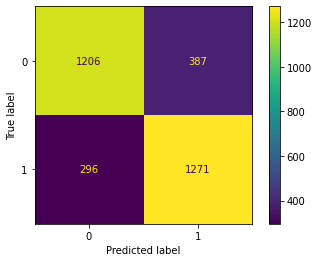

In [ ]:

dataset_b = pd.read_csv(embeddings_balanced_b_path)

dataset_b.drop(columns=['Unnamed: 0'],inplace=True)


dataset_b = dataset_b.to_numpy()


data_X = dataset_b[:,:-1]
data_X = torch.from_numpy(data_X)

data_Y = dataset_b[:,-1]
data_Y = torch.from_numpy(data_Y)

col = dataset_b.shape[1]-1

print('dataset_b.shape:',dataset_b.shape[0],col)

train_dataset = []
test_dataset = []
train_data, test_data = train_test_split(dataset_b,test_size= 0.2,random_state = 2)

sequence_length = 1
input_size = 768
hidden_size = 768
num_layers = 2
num_classes= 2
batch_size = 10
num_iters = 10000
learning_rate = 0.0001  # More power so we can learn faster! previously it was 0.001
check_acc_iter = 1000

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for x in train_data:
  train_dataset.append((torch.from_numpy(x[:-1]),int(x[-1])))

for x in test_data:
  test_dataset.append((torch.from_numpy(x[:-1]),int(x[-1])))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,drop_last=True)   # It's better to shuffle the whole training dataset!

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,drop_last=True)


class RNN_UNI(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
      super(RNN_UNI, self).__init__()
      self.hidden_size= hidden_size
      self.num_layers = num_layers

      self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # For uni Directional RNN
      # self.fc = nn.Linear(hidden_size, num_classes) #For uni Directional

      self.fc_1 = nn.Linear(hidden_size, 512) #For uni Directional
      self.fc_2 = nn.Linear(512, 256) #For uni Directional
      self.fc_3 = nn.Linear(256, 128) #For uni Directional
      self.fc_4 = nn.Linear(128, 64) #For uni Directional
      self.fc_5 = nn.Linear(64, num_classes) #For uni Directional


      self.relu = nn.ReLU()
      self.softmax = nn.Softmax(dim = 1)
      self.dropout = nn.Dropout(.1)


  def forward(self, x):
      # set initial hidden and cell states
      h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) #For uni Directional

      #Forward Propagation
      out, _  = self.rnn(x,h0) #out: tensor of shape (batch size, seq_length, hidden_size)

      # Decode the hidden state of the last time step
      # out = self.fc(out[:, -1, :])

      out = self.fc_1(out[:, -1, :])
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_2(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_3(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_4(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_5(out)


      logits = self.softmax(out)
      return logits
'''
INSTANTIATE MODEL CLASS
'''
model = RNN_UNI( input_size, hidden_size, num_layers, num_classes)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RAdam(model.parameters(), lr=learning_rate)

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
# print(num_epochs)


'''
TRAIN THE MODEL
'''
iter = 0
mx_acc = 0
y_score_pos = []
y_score_neg = []
predictions = []


for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        # print('before:',images.shape)

        images = images.reshape(batch_size, sequence_length, input_size).to(device)

        # print('after:',images.shape)


        labels = labels.to(device)


        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images.float())


        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        if iter % check_acc_iter == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            y_pred = []
            y_true = []
            pos_probs = []
            neg_probs = []
            # Iterate through test dataset
            for i_model, (images, labels) in enumerate(test_loader):

                images = images.reshape(batch_size, sequence_length, input_size).to(device)

                # Forward pass only to get logits/output
                outputs = model(images.float())

                np_output = outputs.detach().cpu().numpy()

                if i_model == 0:
                    predictions = np_output
                else:
                    predictions = np.vstack((predictions, np_output))

                pos_probs.extend(outputs[:,0].tolist())
                neg_probs.extend(outputs[:,1].tolist())

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)

                y_pred.extend(predicted.tolist())
                y_true.extend(labels.tolist())

                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            f1 = f1_score(y_true,y_pred  ,zero_division='warn') * 100
            cohen_kappa = cohen_kappa_score(y_true, y_pred)

            if mx_acc < accuracy:
              mx_acc = accuracy
              y_score_pos = pos_probs
              y_score_neg = neg_probs


            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {:.5f}% F1: {:.2f}% cohen_kappa: {:.4f}'.format(iter, loss.item(), accuracy, f1, cohen_kappa))
            plt_data_balanced.append(('RNN-UNI',iter,'RAdam',loss.item()))

pos_fpr, pos_tpr, pos_thresholds = roc_curve(y_true, y_score_pos  )
neg_fpr, neg_tpr, neg_thresholds = roc_curve(y_true, y_score_neg  )

roc_auc_pos = roc_auc_score(y_true, y_score_pos )
roc_auc_neg = roc_auc_score(y_true, y_score_neg )

plt_ROC_balanced.append((neg_fpr,neg_tpr,roc_auc_pos,'RNN-UNI','RAdam'))

uncertainity = predictive_entropy(predictions)
print("Uncertainity:", uncertainity)

ConfusionMatrixDisplay.from_predictions(
   y_true, y_pred)

plt.show()


#BI - Directional

Adam

dataset_b.shape: 15800 768
Iteration: 1000. Loss: 0.5786424875259399. Accuracy: 68.19620% F1: 74.08% cohen_kappa: 0.3663
Iteration: 2000. Loss: 0.6734998226165771. Accuracy: 73.35443% F1: 68.35% cohen_kappa: 0.4657
Iteration: 3000. Loss: 0.6333329677581787. Accuracy: 77.34177% F1: 77.08% cohen_kappa: 0.5468
Iteration: 4000. Loss: 0.4735030233860016. Accuracy: 75.75949% F1: 72.72% cohen_kappa: 0.5143
Iteration: 5000. Loss: 0.4873018264770508. Accuracy: 76.29747% F1: 76.00% cohen_kappa: 0.5259
Iteration: 6000. Loss: 0.4191652834415436. Accuracy: 76.61392% F1: 78.40% cohen_kappa: 0.5329
Iteration: 7000. Loss: 0.4627750515937805. Accuracy: 78.22785% F1: 78.74% cohen_kappa: 0.5648
Iteration: 8000. Loss: 0.36716073751449585. Accuracy: 77.68987% F1: 78.81% cohen_kappa: 0.5542
Uncertainity: 0.6869761


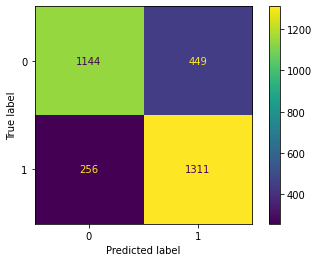

In [ ]:

dataset_b = pd.read_csv(embeddings_balanced_b_path)

dataset_b.drop(columns=['Unnamed: 0'],inplace=True)


dataset_b = dataset_b.to_numpy()


data_X = dataset_b[:,:-1]
data_X = torch.from_numpy(data_X)

data_Y = dataset_b[:,-1]
data_Y = torch.from_numpy(data_Y)

col = dataset_b.shape[1]-1

print('dataset_b.shape:',dataset_b.shape[0],col)

train_dataset = []
test_dataset = []
train_data, test_data = train_test_split(dataset_b,test_size= 0.2,random_state = 2)

sequence_length = 1
input_size = 768
hidden_size = 768
num_layers = 2
num_classes= 2
batch_size = 10
num_iters = 10000
learning_rate = 0.0001  # More power so we can learn faster! previously it was 0.001
check_acc_iter = 1000

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for x in train_data:
  train_dataset.append((torch.from_numpy(x[:-1]),int(x[-1])))

for x in test_data:
  test_dataset.append((torch.from_numpy(x[:-1]),int(x[-1])))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,drop_last=True)   # It's better to shuffle the whole training dataset!

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,drop_last=True)


class RNN_BI(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
      super(RNN_BI, self).__init__()
      self.hidden_size= hidden_size
      self.num_layers = num_layers

      self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True,bidirectional=True) # For uni Directional RNN
      # self.fc = nn.Linear(hidden_size*2, num_classes) #For uni Directional

      self.fc_1 = nn.Linear(hidden_size*2, 512) #For uni Directional
      self.fc_2 = nn.Linear(512, 256) #For uni Directional
      self.fc_3 = nn.Linear(256, 128) #For uni Directional
      self.fc_4 = nn.Linear(128, 64) #For uni Directional
      self.fc_5 = nn.Linear(64, num_classes) #For uni Directional


      self.relu = nn.ReLU()
      self.softmax = nn.Softmax(dim = 1)
      self.dropout = nn.Dropout(.1)


  def forward(self, x):
      # set initial hidden and cell states
      h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) #For uni Directional

      #Forward Propagation
      out, _  = self.rnn(x,h0) #out: tensor of shape (batch size, seq_length, hidden_size)

      # Decode the hidden state of the last time step
      # out = self.fc(out[:, -1, :])

      out = self.fc_1(out[:, -1, :])
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_2(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_3(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_4(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_5(out)

      logits = self.softmax(out)
      return logits
'''
INSTANTIATE MODEL CLASS
'''
model = RNN_BI( input_size, hidden_size, num_layers, num_classes)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
# print(num_epochs)


'''
TRAIN THE MODEL
'''
iter = 0
mx_acc = 0
y_score_pos = []
y_score_neg = []
predictions = []


for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        # print('before:',images.shape)

        images = images.reshape(batch_size, sequence_length, input_size).to(device)

        # print('after:',images.shape)


        labels = labels.to(device)


        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images.float())


        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        if iter % check_acc_iter == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            y_pred = []
            y_true = []
            pos_probs = []
            neg_probs = []
            # Iterate through test dataset
            for i_model, (images, labels) in enumerate(test_loader):

                images = images.reshape(batch_size, sequence_length, input_size).to(device)

                # Forward pass only to get logits/output
                outputs = model(images.float())

                np_output = outputs.detach().cpu().numpy()

                if i_model == 0:
                    predictions = np_output
                else:
                    predictions = np.vstack((predictions, np_output))

                pos_probs.extend(outputs[:,0].tolist())
                neg_probs.extend(outputs[:,1].tolist())

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)

                y_pred.extend(predicted.tolist())
                y_true.extend(labels.tolist())


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            f1 = f1_score(y_true,y_pred  ,zero_division='warn') * 100
            cohen_kappa = cohen_kappa_score(y_true, y_pred)

            if mx_acc < accuracy:
              mx_acc = accuracy
              y_score_pos = pos_probs
              y_score_neg = neg_probs

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {:.5f}% F1: {:.2f}% cohen_kappa: {:.4f}'.format(iter, loss.item(), accuracy, f1, cohen_kappa))
            plt_data_balanced.append(('RNN-BI',iter,'Adam',loss.item()))

pos_fpr, pos_tpr, pos_thresholds = roc_curve(y_true, y_score_pos  )
neg_fpr, neg_tpr, neg_thresholds = roc_curve(y_true, y_score_neg  )

roc_auc_pos = roc_auc_score(y_true, y_score_pos )
roc_auc_neg = roc_auc_score(y_true, y_score_neg )

plt_ROC_balanced.append((neg_fpr,neg_tpr,roc_auc_pos,'RNN-BI','Adam'))

uncertainity = predictive_entropy(predictions)
print("Uncertainity:", uncertainity)

ConfusionMatrixDisplay.from_predictions(
   y_true, y_pred)

plt.show()


NAdam

dataset_b.shape: 15800 768
Iteration: 1000. Loss: 0.4365682601928711. Accuracy: 73.48101% F1: 74.28% cohen_kappa: 0.4699
Iteration: 2000. Loss: 0.5333667993545532. Accuracy: 73.60759% F1: 76.32% cohen_kappa: 0.4732
Iteration: 3000. Loss: 0.49639692902565. Accuracy: 76.89873% F1: 75.86% cohen_kappa: 0.5377
Iteration: 4000. Loss: 0.5362122058868408. Accuracy: 77.81646% F1: 76.80% cohen_kappa: 0.5560
Iteration: 5000. Loss: 0.5295320749282837. Accuracy: 78.13291% F1: 76.97% cohen_kappa: 0.5623
Iteration: 6000. Loss: 0.4902036786079407. Accuracy: 78.25949% F1: 79.34% cohen_kappa: 0.5656
Iteration: 7000. Loss: 0.513879120349884. Accuracy: 78.38608% F1: 78.87% cohen_kappa: 0.5679
Iteration: 8000. Loss: 0.49355554580688477. Accuracy: 73.48101% F1: 68.87% cohen_kappa: 0.4684
Uncertainity: 0.6681868


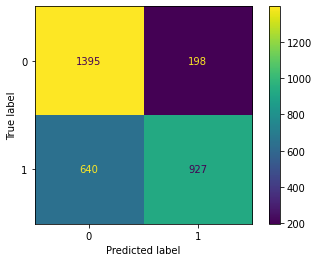

In [ ]:

dataset_b = pd.read_csv(embeddings_balanced_b_path)

dataset_b.drop(columns=['Unnamed: 0'],inplace=True)


dataset_b = dataset_b.to_numpy()


data_X = dataset_b[:,:-1]
data_X = torch.from_numpy(data_X)

data_Y = dataset_b[:,-1]
data_Y = torch.from_numpy(data_Y)

col = dataset_b.shape[1]-1

print('dataset_b.shape:',dataset_b.shape[0],col)

train_dataset = []
test_dataset = []
train_data, test_data = train_test_split(dataset_b,test_size= 0.2,random_state = 2)

sequence_length = 1
input_size = 768
hidden_size = 768
num_layers = 2
num_classes= 2
batch_size = 10
num_iters = 10000
learning_rate = 0.0001  # More power so we can learn faster! previously it was 0.001
check_acc_iter = 1000

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for x in train_data:
  train_dataset.append((torch.from_numpy(x[:-1]),int(x[-1])))

for x in test_data:
  test_dataset.append((torch.from_numpy(x[:-1]),int(x[-1])))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,drop_last=True)   # It's better to shuffle the whole training dataset!

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,drop_last=True)


class RNN_BI(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
      super(RNN_BI, self).__init__()
      self.hidden_size= hidden_size
      self.num_layers = num_layers

      self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True,bidirectional=True) # For uni Directional RNN
      # self.fc = nn.Linear(hidden_size*2, num_classes) #For uni Directional

      self.fc_1 = nn.Linear(hidden_size*2, 512) #For uni Directional
      self.fc_2 = nn.Linear(512, 256) #For uni Directional
      self.fc_3 = nn.Linear(256, 128) #For uni Directional
      self.fc_4 = nn.Linear(128, 64) #For uni Directional
      self.fc_5 = nn.Linear(64, num_classes) #For uni Directional


      self.relu = nn.ReLU()
      self.softmax = nn.Softmax(dim = 1)
      self.dropout = nn.Dropout(.1)


  def forward(self, x):
      # set initial hidden and cell states
      h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) #For uni Directional

      #Forward Propagation
      out, _  = self.rnn(x,h0) #out: tensor of shape (batch size, seq_length, hidden_size)

      # Decode the hidden state of the last time step
      # out = self.fc(out[:, -1, :])

      out = self.fc_1(out[:, -1, :])
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_2(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_3(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_4(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_5(out)

      logits = self.softmax(out)
      return logits
'''
INSTANTIATE MODEL CLASS
'''
model = RNN_BI( input_size, hidden_size, num_layers, num_classes)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
# print(num_epochs)


'''
TRAIN THE MODEL
'''
iter = 0
mx_acc = 0
y_score_pos = []
y_score_neg = []
predictions = []


for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        # print('before:',images.shape)

        images = images.reshape(batch_size, sequence_length, input_size).to(device)

        # print('after:',images.shape)


        labels = labels.to(device)


        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images.float())


        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        if iter % check_acc_iter == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            y_pred = []
            y_true = []
            pos_probs = []
            neg_probs = []
            # Iterate through test dataset
            for i_model, (images, labels) in enumerate(test_loader):

                images = images.reshape(batch_size, sequence_length, input_size).to(device)

                # Forward pass only to get logits/output
                outputs = model(images.float())

                np_output = outputs.detach().cpu().numpy()

                if i_model == 0:
                    predictions = np_output
                else:
                    predictions = np.vstack((predictions, np_output))

                pos_probs.extend(outputs[:,0].tolist())
                neg_probs.extend(outputs[:,1].tolist())

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)

                y_pred.extend(predicted.tolist())
                y_true.extend(labels.tolist())

                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            f1 = f1_score(y_true,y_pred  ,zero_division='warn') * 100
            cohen_kappa = cohen_kappa_score(y_true, y_pred)

            if mx_acc < accuracy:
              mx_acc = accuracy
              y_score_pos = pos_probs
              y_score_neg = neg_probs


            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {:.5f}% F1: {:.2f}% cohen_kappa: {:.4f}'.format(iter, loss.item(), accuracy, f1, cohen_kappa))
            plt_data_balanced.append(('RNN-BI',iter,'NAdam',loss.item()))

pos_fpr, pos_tpr, pos_thresholds = roc_curve(y_true, y_score_pos  )
neg_fpr, neg_tpr, neg_thresholds = roc_curve(y_true, y_score_neg  )

roc_auc_pos = roc_auc_score(y_true, y_score_pos )
roc_auc_neg = roc_auc_score(y_true, y_score_neg )

plt_ROC_balanced.append((neg_fpr,neg_tpr,roc_auc_pos,'RNN-BI','NAdam'))

uncertainity = predictive_entropy(predictions)
print("Uncertainity:", uncertainity)

ConfusionMatrixDisplay.from_predictions(
   y_true, y_pred)

plt.show()

RAdam

dataset_b.shape: 15800 768
Iteration: 1000. Loss: 0.6341346502304077. Accuracy: 73.06962% F1: 72.34% cohen_kappa: 0.4612
Iteration: 2000. Loss: 0.49776941537857056. Accuracy: 75.69620% F1: 74.98% cohen_kappa: 0.5137
Iteration: 3000. Loss: 0.4209962487220764. Accuracy: 76.70886% F1: 77.37% cohen_kappa: 0.5344
Iteration: 4000. Loss: 0.747052788734436. Accuracy: 77.31013% F1: 76.76% cohen_kappa: 0.5461
Iteration: 5000. Loss: 0.5753636360168457. Accuracy: 77.05696% F1: 76.54% cohen_kappa: 0.5410
Iteration: 6000. Loss: 0.4678437113761902. Accuracy: 77.97468% F1: 76.41% cohen_kappa: 0.5590
Iteration: 7000. Loss: 0.44237399101257324. Accuracy: 77.40506% F1: 77.88% cohen_kappa: 0.5483
Iteration: 8000. Loss: 0.564428985118866. Accuracy: 78.35443% F1: 78.52% cohen_kappa: 0.5672
Uncertainity: 0.69298804


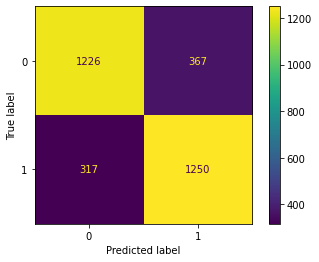

In [ ]:

dataset_b = pd.read_csv(embeddings_balanced_b_path)

dataset_b.drop(columns=['Unnamed: 0'],inplace=True)


dataset_b = dataset_b.to_numpy()


data_X = dataset_b[:,:-1]
data_X = torch.from_numpy(data_X)

data_Y = dataset_b[:,-1]
data_Y = torch.from_numpy(data_Y)

col = dataset_b.shape[1]-1

print('dataset_b.shape:',dataset_b.shape[0],col)

train_dataset = []
test_dataset = []
train_data, test_data = train_test_split(dataset_b,test_size= 0.2,random_state = 2)

sequence_length = 1
input_size = 768
hidden_size = 768
num_layers = 2
num_classes= 2
batch_size = 10
num_iters = 10000
learning_rate = 0.0001  # More power so we can learn faster! previously it was 0.001
check_acc_iter = 1000

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for x in train_data:
  train_dataset.append((torch.from_numpy(x[:-1]),int(x[-1])))

for x in test_data:
  test_dataset.append((torch.from_numpy(x[:-1]),int(x[-1])))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,drop_last=True)   # It's better to shuffle the whole training dataset!

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,drop_last=True)


class RNN_BI(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
      super(RNN_BI, self).__init__()
      self.hidden_size= hidden_size
      self.num_layers = num_layers

      self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True,bidirectional=True) # For uni Directional RNN
      # self.fc = nn.Linear(hidden_size*2, num_classes) #For uni Directional

      self.fc_1 = nn.Linear(hidden_size*2, 512) #For uni Directional
      self.fc_2 = nn.Linear(512, 256) #For uni Directional
      self.fc_3 = nn.Linear(256, 128) #For uni Directional
      self.fc_4 = nn.Linear(128, 64) #For uni Directional
      self.fc_5 = nn.Linear(64, num_classes) #For uni Directional


      self.relu = nn.ReLU()
      self.softmax = nn.Softmax(dim = 1)
      self.dropout = nn.Dropout(.1)


  def forward(self, x):
      # set initial hidden and cell states
      h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) #For uni Directional

      #Forward Propagation
      out, _  = self.rnn(x,h0) #out: tensor of shape (batch size, seq_length, hidden_size)

      # Decode the hidden state of the last time step
      # out = self.fc(out[:, -1, :])

      out = self.fc_1(out[:, -1, :])
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_2(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_3(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_4(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_5(out)

      logits = self.softmax(out)
      return logits
'''
INSTANTIATE MODEL CLASS
'''
model = RNN_BI( input_size, hidden_size, num_layers, num_classes)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RAdam(model.parameters(), lr=learning_rate)

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
# print(num_epochs)


'''
TRAIN THE MODEL
'''
iter = 0
mx_acc = 0
y_score_pos = []
y_score_neg = []
predictions = []


for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        # print('before:',images.shape)

        images = images.reshape(batch_size, sequence_length, input_size).to(device)

        # print('after:',images.shape)


        labels = labels.to(device)


        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images.float())


        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        if iter % check_acc_iter == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            y_pred = []
            y_true = []
            pos_probs = []
            neg_probs = []
            # Iterate through test dataset
            for i_model, (images, labels) in enumerate(test_loader):

                images = images.reshape(batch_size, sequence_length, input_size).to(device)

                # Forward pass only to get logits/output
                outputs = model(images.float())

                np_output = outputs.detach().cpu().numpy()

                if i_model == 0:
                    predictions = np_output
                else:
                    predictions = np.vstack((predictions, np_output))

                pos_probs.extend(outputs[:,0].tolist())
                neg_probs.extend(outputs[:,1].tolist())

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)

                y_pred.extend(predicted.tolist())
                y_true.extend(labels.tolist())


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            f1 = f1_score(y_true,y_pred  ,zero_division='warn') * 100
            cohen_kappa = cohen_kappa_score(y_true, y_pred)

            if mx_acc < accuracy:
              mx_acc = accuracy
              y_score_pos = pos_probs
              y_score_neg = neg_probs

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {:.5f}% F1: {:.2f}% cohen_kappa: {:.4f}'.format(iter, loss.item(), accuracy, f1, cohen_kappa))
            plt_data_balanced.append(('RNN-BI',iter,'RAdam',loss.item()))

pos_fpr, pos_tpr, pos_thresholds = roc_curve(y_true, y_score_pos  )
neg_fpr, neg_tpr, neg_thresholds = roc_curve(y_true, y_score_neg  )

roc_auc_pos = roc_auc_score(y_true, y_score_pos )
roc_auc_neg = roc_auc_score(y_true, y_score_neg )

plt_ROC_balanced.append((neg_fpr,neg_tpr,roc_auc_pos,'RNN-BI','RAdam'))

uncertainity = predictive_entropy(predictions)
print("Uncertainity:", uncertainity)

ConfusionMatrixDisplay.from_predictions(
   y_true, y_pred)

plt.show()


#Imbalanced Dataset

#UNI - Directional

Adam

dataset_b.shape: 15988 768
Iteration: 1000. Loss: 0.5468900203704834. Accuracy: 75.14107% F1: 73.31% cohen_kappa: 0.5012
Iteration: 2000. Loss: 0.5950255393981934. Accuracy: 76.73981% F1: 75.67% cohen_kappa: 0.5340
Iteration: 3000. Loss: 0.6226441860198975. Accuracy: 73.10345% F1: 65.76% cohen_kappa: 0.4557
Iteration: 4000. Loss: 0.6203667521476746. Accuracy: 77.24138% F1: 77.21% cohen_kappa: 0.5452
Iteration: 5000. Loss: 0.47740763425827026. Accuracy: 77.77429% F1: 77.38% cohen_kappa: 0.5554
Iteration: 6000. Loss: 0.7001557350158691. Accuracy: 77.11599% F1: 77.39% cohen_kappa: 0.5430
Iteration: 7000. Loss: 0.6379593014717102. Accuracy: 77.39812% F1: 75.80% cohen_kappa: 0.5466
Iteration: 8000. Loss: 0.6380641460418701. Accuracy: 78.27586% F1: 78.03% cohen_kappa: 0.5656
Uncertainity: 0.6929618


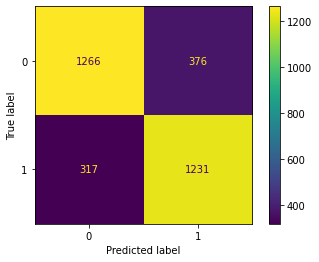

In [ ]:

dataset_b = pd.read_csv(embeddings_balanced_b_path_im)

dataset_b.drop(columns=['Unnamed: 0'],inplace=True)


dataset_b = dataset_b.to_numpy()


data_X = dataset_b[:,:-1]
data_X = torch.from_numpy(data_X)

data_Y = dataset_b[:,-1]
data_Y = torch.from_numpy(data_Y)

col = dataset_b.shape[1]-1

print('dataset_b.shape:',dataset_b.shape[0],col)

train_dataset = []
test_dataset = []
train_data, test_data = train_test_split(dataset_b,test_size= 0.2,random_state = 2)

sequence_length = 1
input_size = 768
hidden_size = 768
num_layers = 2
num_classes= 2
batch_size = 10
num_iters = 10000
learning_rate = 0.0001  # More power so we can learn faster! previously it was 0.001
check_acc_iter = 1000

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for x in train_data:
  train_dataset.append((torch.from_numpy(x[:-1]),int(x[-1])))

for x in test_data:
  test_dataset.append((torch.from_numpy(x[:-1]),int(x[-1])))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,drop_last=True)   # It's better to shuffle the whole training dataset!

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,drop_last=True)


class RNN_UNI(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
      super(RNN_UNI, self).__init__()
      self.hidden_size= hidden_size
      self.num_layers = num_layers

      self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # For uni Directional RNN
      # self.fc = nn.Linear(hidden_size, num_classes) #For uni Directional

      self.fc_1 = nn.Linear(hidden_size, 512) #For uni Directional
      self.fc_2 = nn.Linear(512, 256) #For uni Directional
      self.fc_3 = nn.Linear(256, 128) #For uni Directional
      self.fc_4 = nn.Linear(128, 64) #For uni Directional
      self.fc_5 = nn.Linear(64, num_classes) #For uni Directional


      self.relu = nn.ReLU()
      self.softmax = nn.Softmax(dim = 1)
      self.dropout = nn.Dropout(.1)


  def forward(self, x):
      # set initial hidden and cell states
      h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) #For uni Directional

      #Forward Propagation
      out, _  = self.rnn(x,h0) #out: tensor of shape (batch size, seq_length, hidden_size)

      # Decode the hidden state of the last time step
      # out = self.fc(out[:, -1, :])

      out = self.fc_1(out[:, -1, :])
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_2(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_3(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_4(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_5(out)

      logits = self.softmax(out)
      return logits
'''
INSTANTIATE MODEL CLASS
'''
model = RNN_UNI( input_size, hidden_size, num_layers, num_classes)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
# print(num_epochs)


'''
TRAIN THE MODEL
'''
iter = 0
mx_acc = 0
y_score_pos = []
y_score_neg = []
predictions = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        # print('before:',images.shape)

        images = images.reshape(batch_size, sequence_length, input_size).to(device)

        # print('after:',images.shape)


        labels = labels.to(device)


        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images.float())


        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        if iter % check_acc_iter == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            y_pred = []
            y_true = []
            pos_probs = []
            neg_probs = []
            # Iterate through test dataset
            for i_model, (images, labels) in enumerate(test_loader):

                images = images.reshape(batch_size, sequence_length, input_size).to(device)

                # Forward pass only to get logits/output
                outputs = model(images.float())

                np_output = outputs.detach().cpu().numpy()

                if i_model == 0:
                    predictions = np_output
                else:
                    predictions = np.vstack((predictions, np_output))

                pos_probs.extend(outputs[:,0].tolist())
                neg_probs.extend(outputs[:,1].tolist())

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)

                y_pred.extend(predicted.tolist())
                y_true.extend(labels.tolist())


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            f1 = f1_score(y_true,y_pred  ,zero_division='warn') * 100
            cohen_kappa = cohen_kappa_score(y_true, y_pred)

            if mx_acc < accuracy:
              mx_acc = accuracy
              y_score_pos = pos_probs
              y_score_neg = neg_probs

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {:.5f}% F1: {:.2f}% cohen_kappa: {:.4f}'.format(iter, loss.item(), accuracy, f1, cohen_kappa))
            plt_data_imbalanced.append(('RNN-UNI',iter,'Adam',loss.item()))

pos_fpr, pos_tpr, pos_thresholds = roc_curve(y_true, y_score_pos  )
neg_fpr, neg_tpr, neg_thresholds = roc_curve(y_true, y_score_neg  )

roc_auc_pos = roc_auc_score(y_true, y_score_pos )
roc_auc_neg = roc_auc_score(y_true, y_score_neg )

plt_ROC_imbalanced.append((neg_fpr,neg_tpr,roc_auc_pos,'RNN-UNI','Adam'))

uncertainity = predictive_entropy(predictions)
print("Uncertainity:", uncertainity)

ConfusionMatrixDisplay.from_predictions(
   y_true, y_pred)

plt.show()


NAdam

dataset_b.shape: 15988 768
Iteration: 1000. Loss: 0.5764866471290588. Accuracy: 75.10972% F1: 73.10% cohen_kappa: 0.5004
Iteration: 2000. Loss: 0.6231815218925476. Accuracy: 75.01567% F1: 76.19% cohen_kappa: 0.5022
Iteration: 3000. Loss: 0.45431575179100037. Accuracy: 76.01881% F1: 75.25% cohen_kappa: 0.5199
Iteration: 4000. Loss: 0.5645984411239624. Accuracy: 75.92476% F1: 73.86% cohen_kappa: 0.5167
Iteration: 5000. Loss: 0.4925152659416199. Accuracy: 77.64890% F1: 75.99% cohen_kappa: 0.5515
Iteration: 6000. Loss: 0.731420636177063. Accuracy: 72.19436% F1: 76.18% cohen_kappa: 0.4498
Iteration: 7000. Loss: 0.6134182810783386. Accuracy: 78.11912% F1: 76.27% cohen_kappa: 0.5608
Iteration: 8000. Loss: 0.7200120687484741. Accuracy: 78.43260% F1: 78.10% cohen_kappa: 0.5686
Uncertainity: 0.6931374


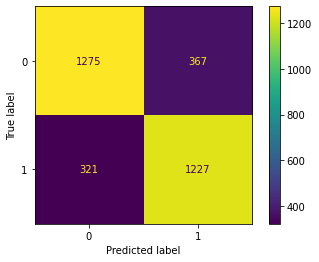

In [ ]:

dataset_b = pd.read_csv(embeddings_balanced_b_path_im)

dataset_b.drop(columns=['Unnamed: 0'],inplace=True)


dataset_b = dataset_b.to_numpy()


data_X = dataset_b[:,:-1]
data_X = torch.from_numpy(data_X)

data_Y = dataset_b[:,-1]
data_Y = torch.from_numpy(data_Y)

col = dataset_b.shape[1]-1

print('dataset_b.shape:',dataset_b.shape[0],col)

train_dataset = []
test_dataset = []
train_data, test_data = train_test_split(dataset_b,test_size= 0.2,random_state = 2)

sequence_length = 1
input_size = 768
hidden_size = 768
num_layers = 2
num_classes= 2
batch_size = 10
num_iters = 10000
learning_rate = 0.0001  # More power so we can learn faster! previously it was 0.001
check_acc_iter = 1000

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for x in train_data:
  train_dataset.append((torch.from_numpy(x[:-1]),int(x[-1])))

for x in test_data:
  test_dataset.append((torch.from_numpy(x[:-1]),int(x[-1])))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,drop_last=True)   # It's better to shuffle the whole training dataset!

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,drop_last=True)


class RNN_UNI(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
      super(RNN_UNI, self).__init__()
      self.hidden_size= hidden_size
      self.num_layers = num_layers

      self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # For uni Directional RNN
      # self.fc = nn.Linear(hidden_size, num_classes) #For uni Directional

      self.fc_1 = nn.Linear(hidden_size, 512) #For uni Directional
      self.fc_2 = nn.Linear(512, 256) #For uni Directional
      self.fc_3 = nn.Linear(256, 128) #For uni Directional
      self.fc_4 = nn.Linear(128, 64) #For uni Directional
      self.fc_5 = nn.Linear(64, num_classes) #For uni Directional


      self.relu = nn.ReLU()
      self.softmax = nn.Softmax(dim = 1)
      self.dropout = nn.Dropout(.1)


  def forward(self, x):
      # set initial hidden and cell states
      h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) #For uni Directional

      #Forward Propagation
      out, _  = self.rnn(x,h0) #out: tensor of shape (batch size, seq_length, hidden_size)

      # Decode the hidden state of the last time step
      # out = self.fc(out[:, -1, :])

      out = self.fc_1(out[:, -1, :])
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_2(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_3(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_4(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_5(out)

      logits = self.softmax(out)
      return logits
'''
INSTANTIATE MODEL CLASS
'''
model = RNN_UNI( input_size, hidden_size, num_layers, num_classes)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
# print(num_epochs)


'''
TRAIN THE MODEL
'''
iter = 0
mx_acc = 0
y_score_pos = []
y_score_neg = []
predictions = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        # print('before:',images.shape)

        images = images.reshape(batch_size, sequence_length, input_size).to(device)

        # print('after:',images.shape)


        labels = labels.to(device)


        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images.float())


        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        if iter % check_acc_iter == 0:
            # Calculate Accuracy
            correct = 0
            total = 0

            y_pred = []
            y_true = []
            pos_probs = []
            neg_probs = []
            # Iterate through test dataset
            for i_model, (images, labels) in enumerate(test_loader):

                images = images.reshape(batch_size, sequence_length, input_size).to(device)

                # Forward pass only to get logits/output
                outputs = model(images.float())

                np_output = outputs.detach().cpu().numpy()

                if i_model == 0:
                    predictions = np_output
                else:
                    predictions = np.vstack((predictions, np_output))

                pos_probs.extend(outputs[:,0].tolist())
                neg_probs.extend(outputs[:,1].tolist())

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)

                y_pred.extend(predicted.tolist())
                y_true.extend(labels.tolist())



                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            f1 = f1_score(y_true,y_pred  ,zero_division='warn') * 100
            cohen_kappa = cohen_kappa_score(y_true, y_pred)

            if mx_acc < accuracy:
              mx_acc = accuracy
              y_score_pos = pos_probs
              y_score_neg = neg_probs

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {:.5f}% F1: {:.2f}% cohen_kappa: {:.4f}'.format(iter, loss.item(), accuracy, f1, cohen_kappa))
            plt_data_imbalanced.append(('RNN-UNI',iter,'NAdam',loss.item()))

pos_fpr, pos_tpr, pos_thresholds = roc_curve(y_true, y_score_pos  )
neg_fpr, neg_tpr, neg_thresholds = roc_curve(y_true, y_score_neg  )

roc_auc_pos = roc_auc_score(y_true, y_score_pos )
roc_auc_neg = roc_auc_score(y_true, y_score_neg )

plt_ROC_imbalanced.append((neg_fpr,neg_tpr,roc_auc_pos,'RNN-UNI','NAdam'))

uncertainity = predictive_entropy(predictions)
print("Uncertainity:", uncertainity)

ConfusionMatrixDisplay.from_predictions(
   y_true, y_pred)

plt.show()


RAdam

dataset_b.shape: 15988 768
Iteration: 1000. Loss: 0.44708251953125. Accuracy: 72.47649% F1: 73.33% cohen_kappa: 0.4510
Iteration: 2000. Loss: 0.59455406665802. Accuracy: 73.54232% F1: 76.13% cohen_kappa: 0.4747
Iteration: 3000. Loss: 0.5931201577186584. Accuracy: 76.45768% F1: 74.29% cohen_kappa: 0.5272
Iteration: 4000. Loss: 0.5483673810958862. Accuracy: 76.20690% F1: 75.65% cohen_kappa: 0.5239
Iteration: 5000. Loss: 0.5760299563407898. Accuracy: 75.79937% F1: 77.32% cohen_kappa: 0.5183
Iteration: 6000. Loss: 0.6060260534286499. Accuracy: 77.86834% F1: 76.48% cohen_kappa: 0.5562
Iteration: 7000. Loss: 0.36992499232292175. Accuracy: 76.26959% F1: 73.09% cohen_kappa: 0.5225
Iteration: 8000. Loss: 0.5478947162628174. Accuracy: 77.39812% F1: 75.78% cohen_kappa: 0.5466
Uncertainity: 0.6894785


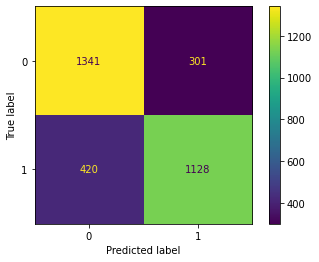

In [ ]:

dataset_b = pd.read_csv(embeddings_balanced_b_path_im)

dataset_b.drop(columns=['Unnamed: 0'],inplace=True)


dataset_b = dataset_b.to_numpy()


data_X = dataset_b[:,:-1]
data_X = torch.from_numpy(data_X)

data_Y = dataset_b[:,-1]
data_Y = torch.from_numpy(data_Y)

col = dataset_b.shape[1]-1

print('dataset_b.shape:',dataset_b.shape[0],col)

train_dataset = []
test_dataset = []
train_data, test_data = train_test_split(dataset_b,test_size= 0.2,random_state = 2)

sequence_length = 1
input_size = 768
hidden_size = 768
num_layers = 2
num_classes= 2
batch_size = 10
num_iters = 10000
learning_rate = 0.0001  # More power so we can learn faster! previously it was 0.001
check_acc_iter = 1000

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for x in train_data:
  train_dataset.append((torch.from_numpy(x[:-1]),int(x[-1])))

for x in test_data:
  test_dataset.append((torch.from_numpy(x[:-1]),int(x[-1])))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,drop_last=True)   # It's better to shuffle the whole training dataset!

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,drop_last=True)


class RNN_UNI(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
      super(RNN_UNI, self).__init__()
      self.hidden_size= hidden_size
      self.num_layers = num_layers

      self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # For uni Directional RNN
      # self.fc = nn.Linear(hidden_size, num_classes) #For uni Directional

      self.fc_1 = nn.Linear(hidden_size, 512) #For uni Directional
      self.fc_2 = nn.Linear(512, 256) #For uni Directional
      self.fc_3 = nn.Linear(256, 128) #For uni Directional
      self.fc_4 = nn.Linear(128, 64) #For uni Directional
      self.fc_5 = nn.Linear(64, num_classes) #For uni Directional


      self.relu = nn.ReLU()
      self.softmax = nn.Softmax(dim = 1)
      self.dropout = nn.Dropout(.1)


  def forward(self, x):
      # set initial hidden and cell states
      h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) #For uni Directional

      #Forward Propagation
      out, _  = self.rnn(x,h0) #out: tensor of shape (batch size, seq_length, hidden_size)

      # Decode the hidden state of the last time step
      # out = self.fc(out[:, -1, :])

      out = self.fc_1(out[:, -1, :])
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_2(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_3(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_4(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_5(out)

      logits = self.softmax(out)
      return logits
'''
INSTANTIATE MODEL CLASS
'''
model = RNN_UNI( input_size, hidden_size, num_layers, num_classes)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RAdam(model.parameters(), lr=learning_rate)

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
# print(num_epochs)


'''
TRAIN THE MODEL
'''
iter = 0
mx_acc = 0
y_score_pos = []
y_score_neg = []
predictions = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        # print('before:',images.shape)

        images = images.reshape(batch_size, sequence_length, input_size).to(device)

        # print('after:',images.shape)


        labels = labels.to(device)


        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images.float())


        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        if iter % check_acc_iter == 0:
            # Calculate Accuracy
            correct = 0
            total = 0

            y_pred = []
            y_true = []
            pos_probs = []
            neg_probs = []
            # Iterate through test dataset
            for i_model, (images, labels) in enumerate(test_loader):

                images = images.reshape(batch_size, sequence_length, input_size).to(device)

                # Forward pass only to get logits/output
                outputs = model(images.float())

                np_output = outputs.detach().cpu().numpy()

                if i_model == 0:
                    predictions = np_output
                else:
                    predictions = np.vstack((predictions, np_output))

                pos_probs.extend(outputs[:,0].tolist())
                neg_probs.extend(outputs[:,1].tolist())

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)

                y_pred.extend(predicted.tolist())
                y_true.extend(labels.tolist())


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            f1 = f1_score(y_true,y_pred  ,zero_division='warn') * 100
            cohen_kappa = cohen_kappa_score(y_true, y_pred)

            if mx_acc < accuracy:
              mx_acc = accuracy
              y_score_pos = pos_probs
              y_score_neg = neg_probs

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {:.5f}% F1: {:.2f}% cohen_kappa: {:.4f}'.format(iter, loss.item(), accuracy, f1, cohen_kappa))
            plt_data_imbalanced.append(('RNN-UNI',iter,'RAdam',loss.item()))

pos_fpr, pos_tpr, pos_thresholds = roc_curve(y_true, y_score_pos  )
neg_fpr, neg_tpr, neg_thresholds = roc_curve(y_true, y_score_neg  )

roc_auc_pos = roc_auc_score(y_true, y_score_pos )
roc_auc_neg = roc_auc_score(y_true, y_score_neg )

plt_ROC_imbalanced.append((neg_fpr,neg_tpr,roc_auc_pos,'RNN-UNI','RAdam'))

uncertainity = predictive_entropy(predictions)
print("Uncertainity:", uncertainity)

ConfusionMatrixDisplay.from_predictions(
   y_true, y_pred)

plt.show()


#BI - Directional

Adam

dataset_b.shape: 15988 768
Iteration: 1000. Loss: 0.4250263273715973. Accuracy: 75.26646% F1: 72.19% cohen_kappa: 0.5025
Iteration: 2000. Loss: 0.6576478481292725. Accuracy: 76.45768% F1: 74.00% cohen_kappa: 0.5269
Iteration: 3000. Loss: 0.40903934836387634. Accuracy: 77.39812% F1: 76.26% cohen_kappa: 0.5471
Iteration: 4000. Loss: 0.5418521165847778. Accuracy: 77.39812% F1: 77.25% cohen_kappa: 0.5482
Iteration: 5000. Loss: 0.534572184085846. Accuracy: 70.68966% F1: 75.30% cohen_kappa: 0.4207
Iteration: 6000. Loss: 0.4037536084651947. Accuracy: 76.64577% F1: 77.93% cohen_kappa: 0.5349
Iteration: 7000. Loss: 0.5222521424293518. Accuracy: 77.11599% F1: 77.36% cohen_kappa: 0.5430
Iteration: 8000. Loss: 0.3337099254131317. Accuracy: 76.01881% F1: 77.76% cohen_kappa: 0.5230
Uncertainity: 0.6727092


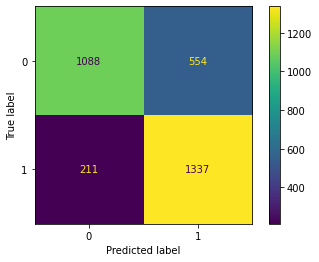

In [ ]:

dataset_b = pd.read_csv(embeddings_balanced_b_path_im)

dataset_b.drop(columns=['Unnamed: 0'],inplace=True)


dataset_b = dataset_b.to_numpy()


data_X = dataset_b[:,:-1]
data_X = torch.from_numpy(data_X)

data_Y = dataset_b[:,-1]
data_Y = torch.from_numpy(data_Y)

col = dataset_b.shape[1]-1

print('dataset_b.shape:',dataset_b.shape[0],col)

train_dataset = []
test_dataset = []
train_data, test_data = train_test_split(dataset_b,test_size= 0.2,random_state = 2)

sequence_length = 1
input_size = 768
hidden_size = 768
num_layers = 2
num_classes= 2
batch_size = 10
num_iters = 10000
learning_rate = 0.0001  # More power so we can learn faster! previously it was 0.001
check_acc_iter = 1000

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for x in train_data:
  train_dataset.append((torch.from_numpy(x[:-1]),int(x[-1])))

for x in test_data:
  test_dataset.append((torch.from_numpy(x[:-1]),int(x[-1])))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,drop_last=True)   # It's better to shuffle the whole training dataset!

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,drop_last=True)


class RNN_BI(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
      super(RNN_BI, self).__init__()
      self.hidden_size= hidden_size
      self.num_layers = num_layers

      self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True,bidirectional=True) # For uni Directional RNN
      # self.fc = nn.Linear(hidden_size*2, num_classes) #For uni Directional

      self.fc_1 = nn.Linear(hidden_size*2, 512) #For uni Directional
      self.fc_2 = nn.Linear(512, 256) #For uni Directional
      self.fc_3 = nn.Linear(256, 128) #For uni Directional
      self.fc_4 = nn.Linear(128, 64) #For uni Directional
      self.fc_5 = nn.Linear(64, num_classes) #For uni Directional


      self.relu = nn.ReLU()
      self.softmax = nn.Softmax(dim = 1)
      self.dropout = nn.Dropout(.1)


  def forward(self, x):
      # set initial hidden and cell states
      h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) #For uni Directional

      #Forward Propagation
      out, _  = self.rnn(x,h0) #out: tensor of shape (batch size, seq_length, hidden_size)

      # Decode the hidden state of the last time step
      # out = self.fc(out[:, -1, :])

      out = self.fc_1(out[:, -1, :])
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_2(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_3(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_4(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_5(out)

      logits = self.softmax(out)
      return logits
'''
INSTANTIATE MODEL CLASS
'''
model = RNN_BI( input_size, hidden_size, num_layers, num_classes)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
# print(num_epochs)


'''
TRAIN THE MODEL
'''
iter = 0
mx_acc = 0
y_score_pos = []
y_score_neg = []
predictions = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        # print('before:',images.shape)

        images = images.reshape(batch_size, sequence_length, input_size).to(device)

        # print('after:',images.shape)


        labels = labels.to(device)


        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images.float())

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        if iter % check_acc_iter == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            y_pred = []
            y_true = []
            pos_probs = []
            neg_probs = []
            # Iterate through test dataset
            for i_model, (images, labels) in enumerate(test_loader):

                images = images.reshape(batch_size, sequence_length, input_size).to(device)

                # Forward pass only to get logits/output
                outputs = model(images.float())

                np_output = outputs.detach().cpu().numpy()

                if i_model == 0:
                    predictions = np_output
                else:
                    predictions = np.vstack((predictions, np_output))

                pos_probs.extend(outputs[:,0].tolist())
                neg_probs.extend(outputs[:,1].tolist())

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)

                y_pred.extend(predicted.tolist())
                y_true.extend(labels.tolist())


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            f1 = f1_score(y_true,y_pred  ,zero_division='warn') * 100
            cohen_kappa = cohen_kappa_score(y_true, y_pred)

            if mx_acc < accuracy:
              mx_acc = accuracy
              y_score_pos = pos_probs
              y_score_neg = neg_probs

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {:.5f}% F1: {:.2f}% cohen_kappa: {:.4f}'.format(iter, loss.item(), accuracy, f1, cohen_kappa))
            plt_data_imbalanced.append(('RNN-BI',iter,'Adam',loss.item()))

pos_fpr, pos_tpr, pos_thresholds = roc_curve(y_true, y_score_pos  )
neg_fpr, neg_tpr, neg_thresholds = roc_curve(y_true, y_score_neg  )

roc_auc_pos = roc_auc_score(y_true, y_score_pos )
roc_auc_neg = roc_auc_score(y_true, y_score_neg )

plt_ROC_imbalanced.append((neg_fpr,neg_tpr,roc_auc_pos,'RNN-BI','Adam'))


uncertainity = predictive_entropy(predictions)
print("Uncertainity:", uncertainity)

ConfusionMatrixDisplay.from_predictions(
   y_true, y_pred)

plt.show()


NAdam

dataset_b.shape: 15988 768
Iteration: 1000. Loss: 0.5789219737052917. Accuracy: 74.10658% F1: 70.89% cohen_kappa: 0.4792
Iteration: 2000. Loss: 0.4780232012271881. Accuracy: 75.51724% F1: 73.06% cohen_kappa: 0.5081
Iteration: 3000. Loss: 0.575313150882721. Accuracy: 73.54232% F1: 75.82% cohen_kappa: 0.4742
Iteration: 4000. Loss: 0.4153507351875305. Accuracy: 77.39812% F1: 75.32% cohen_kappa: 0.5461
Iteration: 5000. Loss: 0.6432496309280396. Accuracy: 74.10658% F1: 76.76% cohen_kappa: 0.4860
Iteration: 6000. Loss: 0.50178062915802. Accuracy: 77.33542% F1: 78.19% cohen_kappa: 0.5481
Iteration: 7000. Loss: 0.4340871274471283. Accuracy: 77.58621% F1: 77.61% cohen_kappa: 0.5521
Iteration: 8000. Loss: 0.6350421905517578. Accuracy: 77.71160% F1: 75.42% cohen_kappa: 0.5522
Uncertainity: 0.6770538


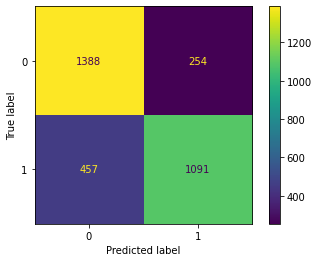

In [ ]:

dataset_b = pd.read_csv(embeddings_balanced_b_path_im)

dataset_b.drop(columns=['Unnamed: 0'],inplace=True)


dataset_b = dataset_b.to_numpy()


data_X = dataset_b[:,:-1]
data_X = torch.from_numpy(data_X)

data_Y = dataset_b[:,-1]
data_Y = torch.from_numpy(data_Y)

col = dataset_b.shape[1]-1

print('dataset_b.shape:',dataset_b.shape[0],col)

train_dataset = []
test_dataset = []
train_data, test_data = train_test_split(dataset_b,test_size= 0.2,random_state = 2)

sequence_length = 1
input_size = 768
hidden_size = 768
num_layers = 2
num_classes= 2
batch_size = 10
num_iters = 10000
learning_rate = 0.0001  # More power so we can learn faster! previously it was 0.001
check_acc_iter = 1000

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for x in train_data:
  train_dataset.append((torch.from_numpy(x[:-1]),int(x[-1])))

for x in test_data:
  test_dataset.append((torch.from_numpy(x[:-1]),int(x[-1])))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,drop_last=True)   # It's better to shuffle the whole training dataset!

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,drop_last=True)


class RNN_BI(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
      super(RNN_BI, self).__init__()
      self.hidden_size= hidden_size
      self.num_layers = num_layers

      self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True,bidirectional=True) # For uni Directional RNN
      # self.fc = nn.Linear(hidden_size*2, num_classes) #For uni Directional

      self.fc_1 = nn.Linear(hidden_size*2, 512) #For uni Directional
      self.fc_2 = nn.Linear(512, 256) #For uni Directional
      self.fc_3 = nn.Linear(256, 128) #For uni Directional
      self.fc_4 = nn.Linear(128, 64) #For uni Directional
      self.fc_5 = nn.Linear(64, num_classes) #For uni Directional


      self.relu = nn.ReLU()
      self.softmax = nn.Softmax(dim = 1)
      self.dropout = nn.Dropout(.1)


  def forward(self, x):
      # set initial hidden and cell states
      h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) #For uni Directional

      #Forward Propagation
      out, _  = self.rnn(x,h0) #out: tensor of shape (batch size, seq_length, hidden_size)

      # Decode the hidden state of the last time step
      # out = self.fc(out[:, -1, :])

      out = self.fc_1(out[:, -1, :])
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_2(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_3(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_4(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_5(out)

      logits = self.softmax(out)
      return logits
'''
INSTANTIATE MODEL CLASS
'''
model = RNN_BI( input_size, hidden_size, num_layers, num_classes)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
# print(num_epochs)


'''
TRAIN THE MODEL
'''
iter = 0
mx_acc = 0
y_score_pos = []
y_score_neg = []
predictions = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        # print('before:',images.shape)

        images = images.reshape(batch_size, sequence_length, input_size).to(device)

        # print('after:',images.shape)


        labels = labels.to(device)


        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images.float())


        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        if iter % check_acc_iter == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            y_pred = []
            y_true = []
            pos_probs = []
            neg_probs = []
            # Iterate through test dataset
            for i_model, (images, labels) in enumerate(test_loader):

                images = images.reshape(batch_size, sequence_length, input_size).to(device)

                # Forward pass only to get logits/output
                outputs = model(images.float())

                np_output = outputs.detach().cpu().numpy()

                if i_model == 0:
                    predictions = np_output
                else:
                    predictions = np.vstack((predictions, np_output))

                pos_probs.extend(outputs[:,0].tolist())
                neg_probs.extend(outputs[:,1].tolist())

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)

                y_pred.extend(predicted.tolist())
                y_true.extend(labels.tolist())


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            f1 = f1_score(y_true,y_pred  ,zero_division='warn') * 100
            cohen_kappa = cohen_kappa_score(y_true, y_pred)

            if mx_acc < accuracy:
              mx_acc = accuracy
              y_score_pos = pos_probs
              y_score_neg = neg_probs

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {:.5f}% F1: {:.2f}% cohen_kappa: {:.4f}'.format(iter, loss.item(), accuracy, f1, cohen_kappa))
            plt_data_imbalanced.append(('RNN-BI',iter,'NAdam',loss.item()))

pos_fpr, pos_tpr, pos_thresholds = roc_curve(y_true, y_score_pos  )
neg_fpr, neg_tpr, neg_thresholds = roc_curve(y_true, y_score_neg  )

roc_auc_pos = roc_auc_score(y_true, y_score_pos )
roc_auc_neg = roc_auc_score(y_true, y_score_neg )

plt_ROC_imbalanced.append((neg_fpr,neg_tpr,roc_auc_pos,'RNN-BI','NAdam'))

uncertainity = predictive_entropy(predictions)
print("Uncertainity:", uncertainity)

ConfusionMatrixDisplay.from_predictions(
   y_true, y_pred)

plt.show()


RAdam

dataset_b.shape: 15988 768
Iteration: 1000. Loss: 0.7206093668937683. Accuracy: 73.44828% F1: 72.84% cohen_kappa: 0.4687
Iteration: 2000. Loss: 0.7354370355606079. Accuracy: 74.04389% F1: 71.51% cohen_kappa: 0.4786
Iteration: 3000. Loss: 0.36151447892189026. Accuracy: 76.86520% F1: 75.25% cohen_kappa: 0.5359
Iteration: 4000. Loss: 0.38194459676742554. Accuracy: 77.08464% F1: 76.80% cohen_kappa: 0.5418
Iteration: 5000. Loss: 0.5458850860595703. Accuracy: 77.77429% F1: 77.20% cohen_kappa: 0.5552
Iteration: 6000. Loss: 0.4368963837623596. Accuracy: 76.99060% F1: 74.55% cohen_kappa: 0.5376
Iteration: 7000. Loss: 0.3846377730369568. Accuracy: 75.48589% F1: 71.27% cohen_kappa: 0.5059
Iteration: 8000. Loss: 0.6072298884391785. Accuracy: 75.51724% F1: 78.04% cohen_kappa: 0.5141
Uncertainity: 0.653972


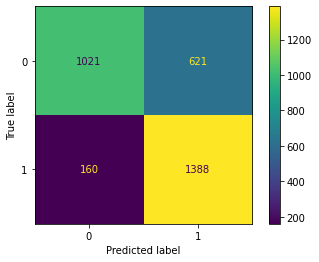

In [ ]:

dataset_b = pd.read_csv(embeddings_balanced_b_path_im)

dataset_b.drop(columns=['Unnamed: 0'],inplace=True)


dataset_b = dataset_b.to_numpy()


data_X = dataset_b[:,:-1]
data_X = torch.from_numpy(data_X)

data_Y = dataset_b[:,-1]
data_Y = torch.from_numpy(data_Y)

col = dataset_b.shape[1]-1

print('dataset_b.shape:',dataset_b.shape[0],col)

train_dataset = []
test_dataset = []
train_data, test_data = train_test_split(dataset_b,test_size= 0.2,random_state = 2)

sequence_length = 1
input_size = 768
hidden_size = 768
num_layers = 2
num_classes= 2
batch_size = 10
num_iters = 10000
learning_rate = 0.0001  # More power so we can learn faster! previously it was 0.001
check_acc_iter = 1000

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for x in train_data:
  train_dataset.append((torch.from_numpy(x[:-1]),int(x[-1])))

for x in test_data:
  test_dataset.append((torch.from_numpy(x[:-1]),int(x[-1])))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,drop_last=True)   # It's better to shuffle the whole training dataset!

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,drop_last=True)


class RNN_BI(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
      super(RNN_BI, self).__init__()
      self.hidden_size= hidden_size
      self.num_layers = num_layers

      self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True,bidirectional=True) # For uni Directional RNN
      # self.fc = nn.Linear(hidden_size*2, num_classes) #For uni Directional

      self.fc_1 = nn.Linear(hidden_size*2, 512) #For uni Directional
      self.fc_2 = nn.Linear(512, 256) #For uni Directional
      self.fc_3 = nn.Linear(256, 128) #For uni Directional
      self.fc_4 = nn.Linear(128, 64) #For uni Directional
      self.fc_5 = nn.Linear(64, num_classes) #For uni Directional


      self.relu = nn.ReLU()
      self.softmax = nn.Softmax(dim = 1)
      self.dropout = nn.Dropout(.1)


  def forward(self, x):
      # set initial hidden and cell states
      h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) #For uni Directional

      #Forward Propagation
      out, _  = self.rnn(x,h0) #out: tensor of shape (batch size, seq_length, hidden_size)

      # Decode the hidden state of the last time step
      # out = self.fc(out[:, -1, :])

      out = self.fc_1(out[:, -1, :])
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_2(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_3(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_4(out)
      out = self.dropout(out)
      out = self.relu(out)

      out = self.fc_5(out)

      logits = self.softmax(out)
      return logits
'''
INSTANTIATE MODEL CLASS
'''
model = RNN_BI( input_size, hidden_size, num_layers, num_classes)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RAdam(model.parameters(), lr=learning_rate)

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
# print(num_epochs)


'''
TRAIN THE MODEL
'''
iter = 0
mx_acc = 0
y_score_pos = []
y_score_neg = []
predictions = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        # print('before:',images.shape)

        images = images.reshape(batch_size, sequence_length, input_size).to(device)

        # print('after:',images.shape)


        labels = labels.to(device)


        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images.float())


        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        if iter % check_acc_iter == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            y_pred = []
            y_true = []
            pos_probs = []
            neg_probs = []
            # Iterate through test dataset
            for i_model, (images, labels) in enumerate(test_loader):

                images = images.reshape(batch_size, sequence_length, input_size).to(device)

                # Forward pass only to get logits/output
                outputs = model(images.float())

                np_output = outputs.detach().cpu().numpy()

                if i_model == 0:
                    predictions = np_output
                else:
                    predictions = np.vstack((predictions, np_output))

                pos_probs.extend(outputs[:,0].tolist())
                neg_probs.extend(outputs[:,1].tolist())

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)

                y_pred.extend(predicted.tolist())
                y_true.extend(labels.tolist())


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            f1 = f1_score(y_true,y_pred  ,zero_division='warn') * 100
            cohen_kappa = cohen_kappa_score(y_true, y_pred)

            if mx_acc < accuracy:
              mx_acc = accuracy
              y_score_pos = pos_probs
              y_score_neg = neg_probs

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {:.5f}% F1: {:.2f}% cohen_kappa: {:.4f}'.format(iter, loss.item(), accuracy, f1, cohen_kappa))
            plt_data_imbalanced.append(('RNN-BI',iter,'RAdam',loss.item()))

pos_fpr, pos_tpr, pos_thresholds = roc_curve(y_true, y_score_pos  )
neg_fpr, neg_tpr, neg_thresholds = roc_curve(y_true, y_score_neg  )

roc_auc_pos = roc_auc_score(y_true, y_score_pos )
roc_auc_neg = roc_auc_score(y_true, y_score_neg )

plt_ROC_imbalanced.append((neg_fpr,neg_tpr,roc_auc_pos,'RNN-BI','RAdam'))

uncertainity = predictive_entropy(predictions)
print("Uncertainity:", uncertainity)

ConfusionMatrixDisplay.from_predictions(
   y_true, y_pred)

plt.show()


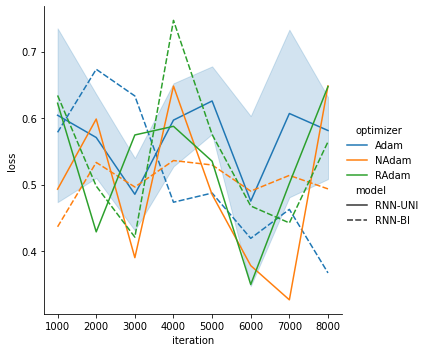

In [ ]:
# loss function plot for balanced dataset

plt_df = pd.DataFrame.from_records(
    plt_data_balanced, columns=['model','iteration','optimizer','loss'])
sns.relplot(x="iteration", y="loss",
            hue="optimizer", style="model",
            kind="line", data=plt_df)

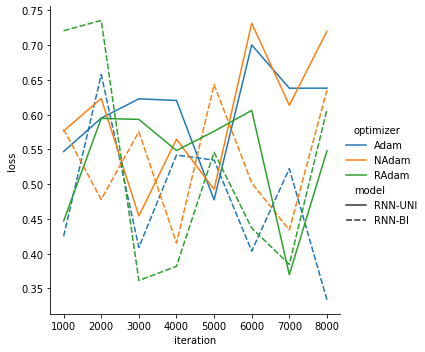

In [ ]:
# loss function plot for imbalanced dataset

plt_df = pd.DataFrame.from_records(
    plt_data_imbalanced, columns=['model','iteration','optimizer','loss'])
sns.relplot(x="iteration", y="loss",
            hue="optimizer", style="model",
            kind="line", data=plt_df)

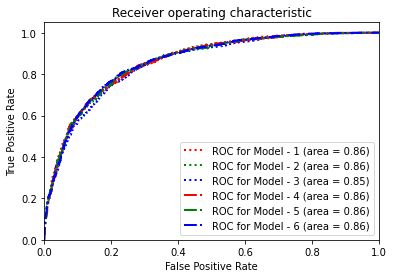

In [ ]:
# plot ROC for blanaced dataset
plt.figure()
lw = 2

colors = ['red','green','blue']

for i in range(3):
  plt.plot(
      plt_ROC_balanced[i][0],
      plt_ROC_balanced[i][1],
      color=colors[i],
      lw=lw,
      linestyle="dotted",
      label="ROC for Model - %d (area = %0.2f)" % (i+1,1 - plt_ROC_balanced[i][2]))

for i in range(3,6):
  plt.plot(
      plt_ROC_balanced[i][0],
      plt_ROC_balanced[i][1],
      color=colors[i-3],
      lw=lw,
      linestyle="dashdot",
      label="ROC for Model - %d (area = %0.2f)" % (i+1,1 - plt_ROC_balanced[i][2]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="best")
plt.show()

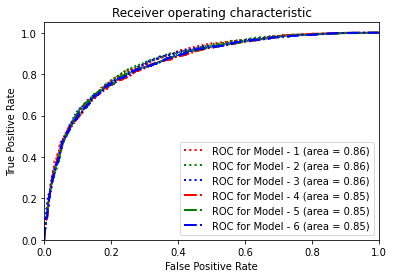

In [ ]:
# plot ROC for imblanaced dataset

plt.figure()
lw = 2
colors = ['red','green','blue']

for i in range(3):
  plt.plot(
      plt_ROC_imbalanced[i][0],
      plt_ROC_imbalanced[i][1],
      color=colors[i],
      lw=lw,
      linestyle="dotted",
      label="ROC for Model - %d (area = %0.2f)" % (i+1,1 - plt_ROC_imbalanced[i][2]))

for i in range(3,6):
  plt.plot(
      plt_ROC_imbalanced[i][0],
      plt_ROC_imbalanced[i][1],
      color=colors[i-3],
      lw=lw,
      linestyle="dashdot",
      label="ROC for Model - %d (area = %0.2f)" % (i+1,1 - plt_ROC_imbalanced[i][2]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="best")
plt.show()

In [ ]:
import datetime
ct = datetime.datetime.now()
print("current time:-", ct)

current time:- 2023-03-05 14:09:18.107246
